In [83]:
import pandas as pd
import numpy as np
from urllib.request import urlopen

In [525]:
from glob import glob
import lightkurve as lk
from astropy.io import fits
import astropy.units as u
from astropy.stats import LombScargle
from astropy.coordinates import SkyCoord, Angle
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
plt.style.use(lk.MPLSTYLE)

In [483]:
k2_asteriks = pd.read_csv('/Users/ch/K2/projects/asteriks/asteriks/data/CAF_with_proposers.csv')

In [656]:
def get_params(name, spacecraft='Kepler'):
    if spacecraft is 'Kepler':
        key = '500@-227'
    if spacecraft is 'TESS':
        key = '500@-95'
        
    HORIZONS_URL = ("https://ssd.jpl.nasa.gov/horizons_batch.cgi?"
                    "batch=1&"
                    "COMMAND=%27{0}%27&"
                    "MAKE_EPHEM=%27YES%27%20&"
                    "CENTER=%27{4}%27&"
                    "TABLE_TYPE=%27OBSERVER%27&"
                    "START_TIME=%27{1}%27&"
                    "STOP_TIME=%27{2}%27&"
                    "STEP_SIZE=%27{3}%27%20&"
                    "ANG_FORMAT=%27DEG%27&"
                    "QUANTITIES=%271,3,9%27&"
                    "CSV_FORMAT=%27YES%27".format(name.replace(' ', '%27'), 2458682.5, 2459035.5, 10, key))
    res = str(urlopen(HORIZONS_URL).read())
    print(res.replace('\\n', '\n'))
    try:
        inc = float(res.split('IN=')[-1].split('\\n')[0])
    except:
        inc = np.nan
        
    try:
        ecc = float(res.split('EC=')[-1].split('QR=')[0])
    except:
        ecc = np.nan

    try:
        per = float(res.split('ROTPER=')[-1].split('\\n')[0])
    except:
        per = np.nan
    try:
        a = float(res.split('A=')[1].split('M')[0])
    except:
        a = np.nan
    try:
        rad = float(res.split('RAD=')[1].split('ROTP')[0])
    except:
        rad = np.nan
    return a, per, ecc, inc, rad

In [510]:
k2 = pd.DataFrame(columns=['name', 'a', 'per', 'ecc', 'inc', 'rad'])
for idx, name in enumerate(tqdm(k2_asteriks.clean_name)):
    a, per, ecc, inc, rad = get_params(name, 'Kepler')
    k2.loc[idx, k2.columns] = np.asarray([name, a, per, ecc, inc, rad]).T


  4%|▍         | 13/295 [00:07<02:33,  1.84it/s]
Exception in thread Thread-26:
Traceback (most recent call last):
  File "/Users/ch/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ch/miniconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ch/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 295/295 [02:04<00:00,  2.37it/s]


In [571]:
cycle2 = pd.read_csv('tess_cycle_2_prediction.dat')
# Create catalog
result = None
for field in tqdm(np.arange(13)):
    for camera in [1, 2, 3, 4]:
        ra = cycle2[f'Cam{camera}RA'][field]
        dec = cycle2[f'Cam{camera}Dec'][field]
        df = pd.read_hdf(f'catalog/sector{field}-camera{camera}.hf5')
        if len(df) == 0:
            continue
        crd_camera = SkyCoord(ra, dec, unit='deg').barycentrictrueecliptic
        crd_asteroids = SkyCoord(df['RA(h)'], df['DE(deg)'], unit=(u.hourangle, u.deg)).barycentrictrueecliptic
        mask = ((crd_asteroids.lon.deg > (crd_camera.lon.deg - 12))
                & (crd_asteroids.lon.deg < (crd_camera.lon.deg + 12))
                & (crd_asteroids.lat.deg > (crd_camera.lat.deg - 12))
                & (crd_asteroids.lat.deg < (crd_camera.lat.deg + 12))
               )
        if result is None:
            result = df[mask]
        else:
            result = result.append(df[mask])

100%|██████████| 13/13 [00:58<00:00,  4.47s/it]


In [572]:
print(len(result))

95686


In [573]:
result = result[result.Mv < 18]

In [574]:
print(len(result))

4614


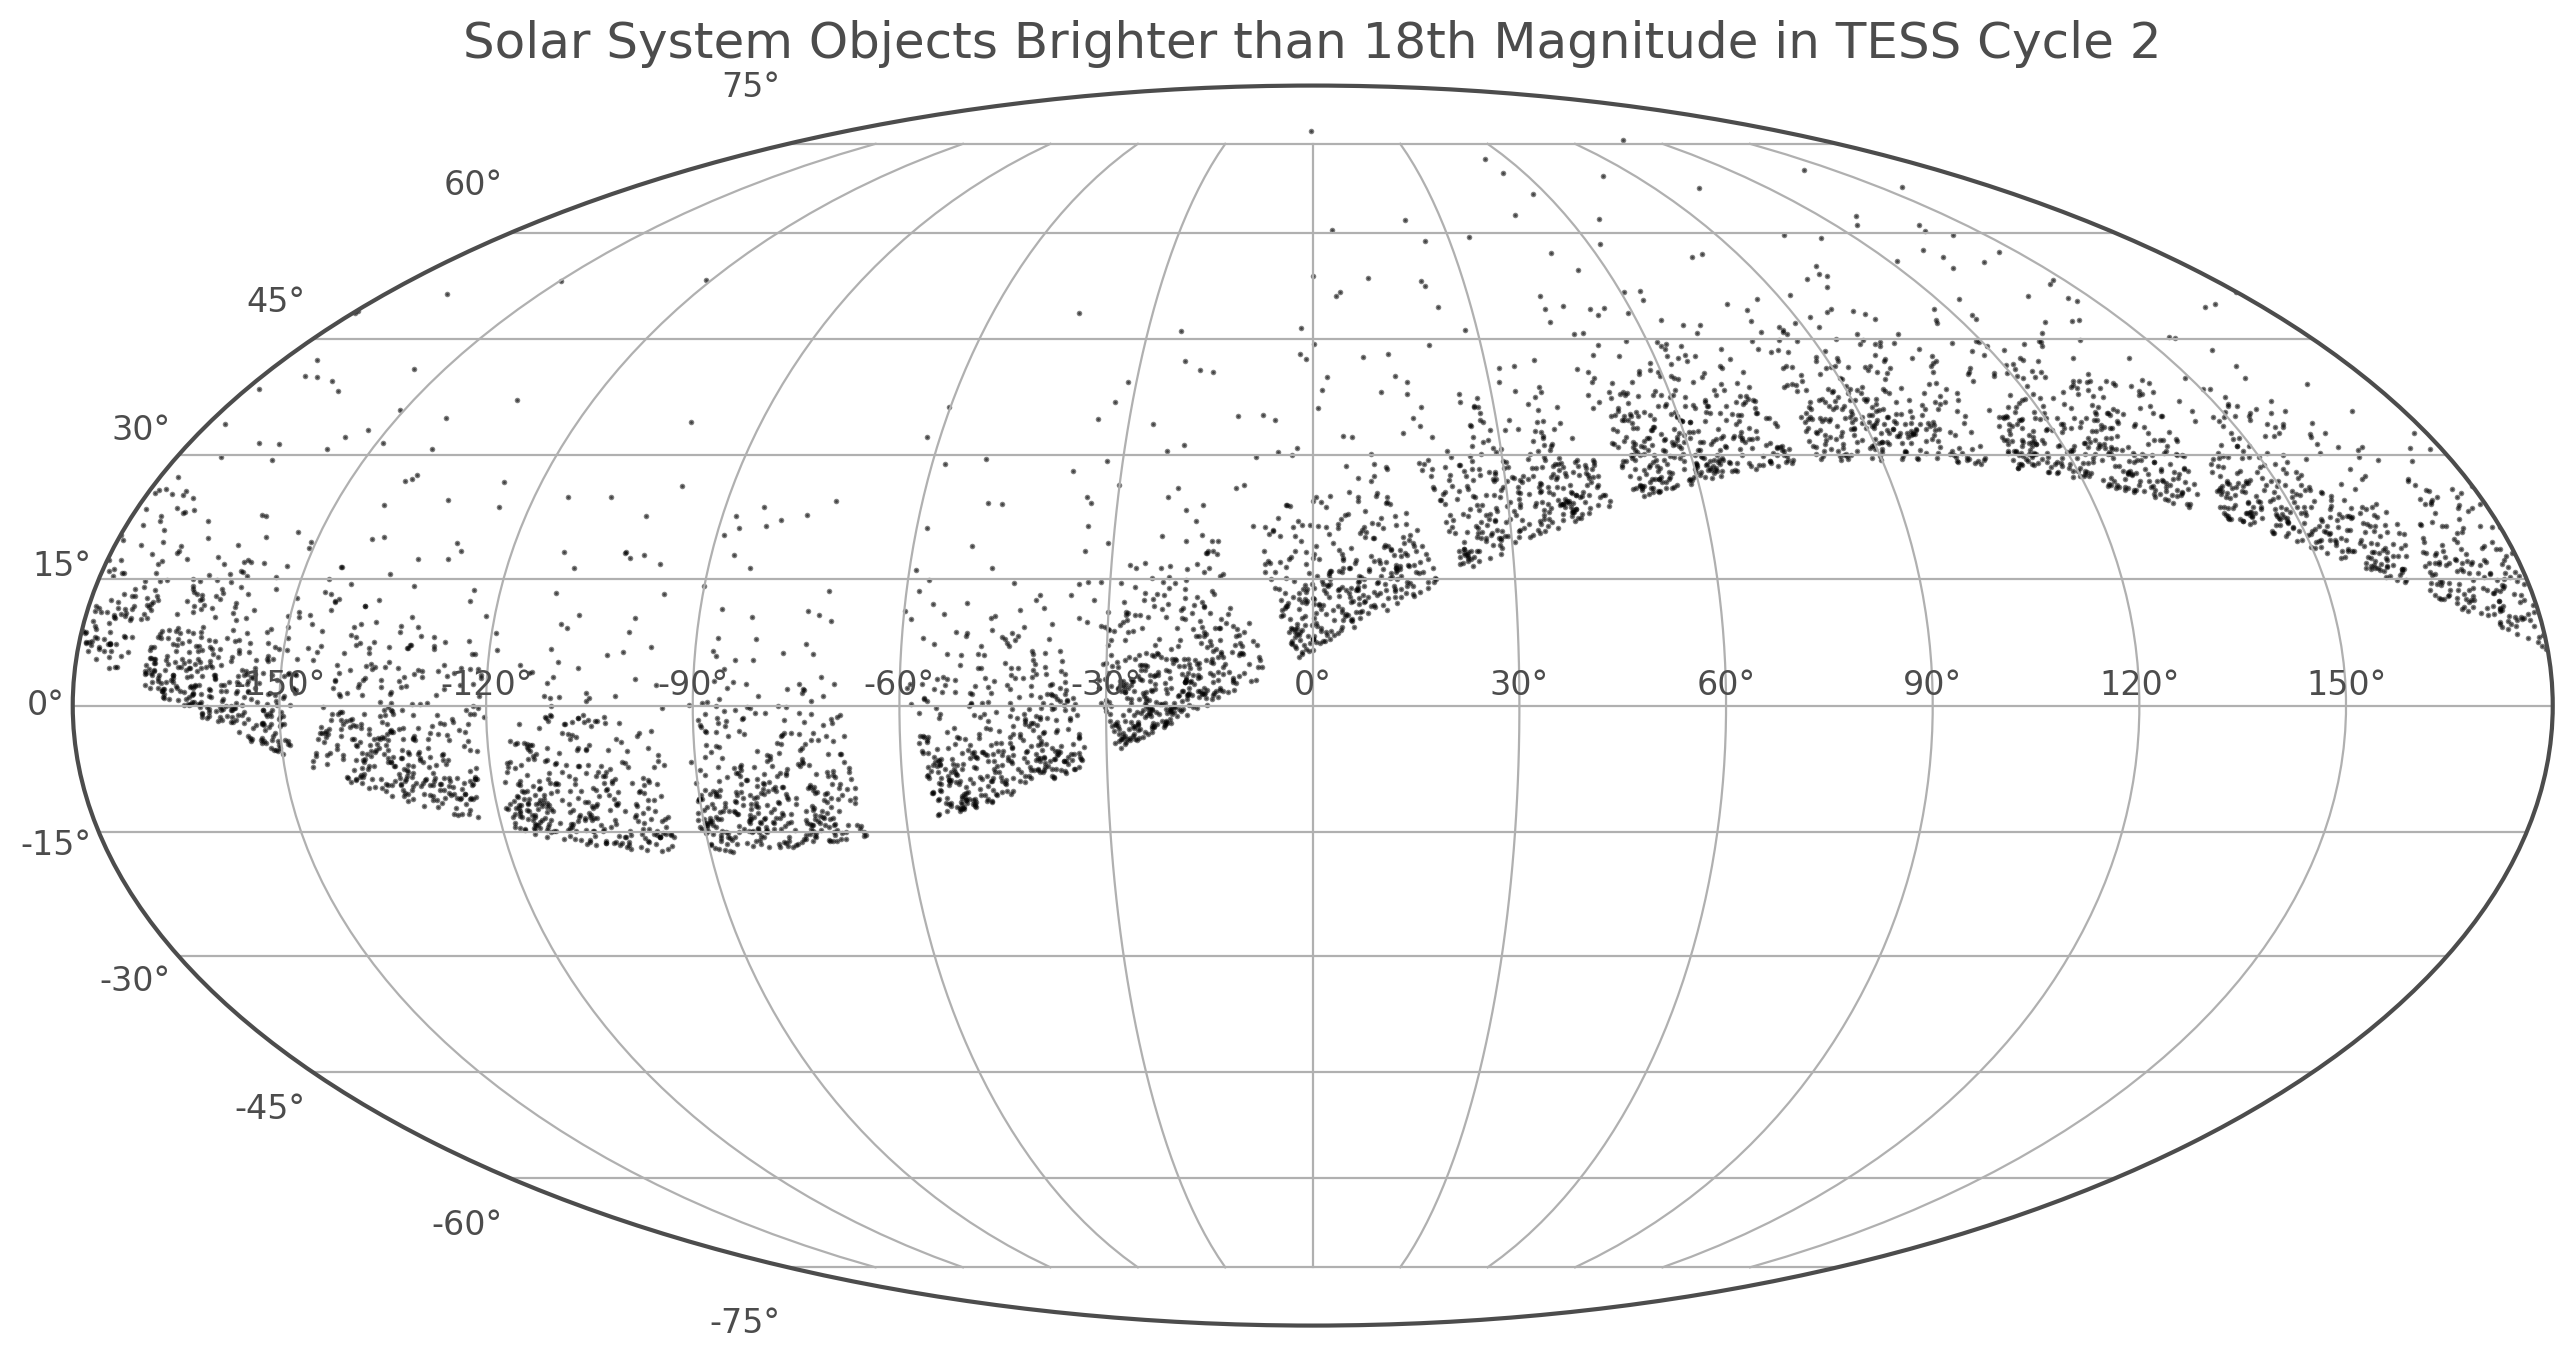

In [576]:
c = SkyCoord(result['RA(h)'], result['DE(deg)'], unit=(u.hourangle, u.deg))
fig = plt.figure(figsize=(8*2, 4.2*2))
ax = plt.subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(Angle(c.ra.wrap_at(180*u.deg)).radian, Angle(c.dec).radian, c='k', alpha=0.5, s=1)
ax.set_title('Solar System Objects Brighter than 18th Magnitude in TESS Cycle 2')
plt.savefig('figures/tess_field_v18.png', bbox_inches='tight', dpi=200)

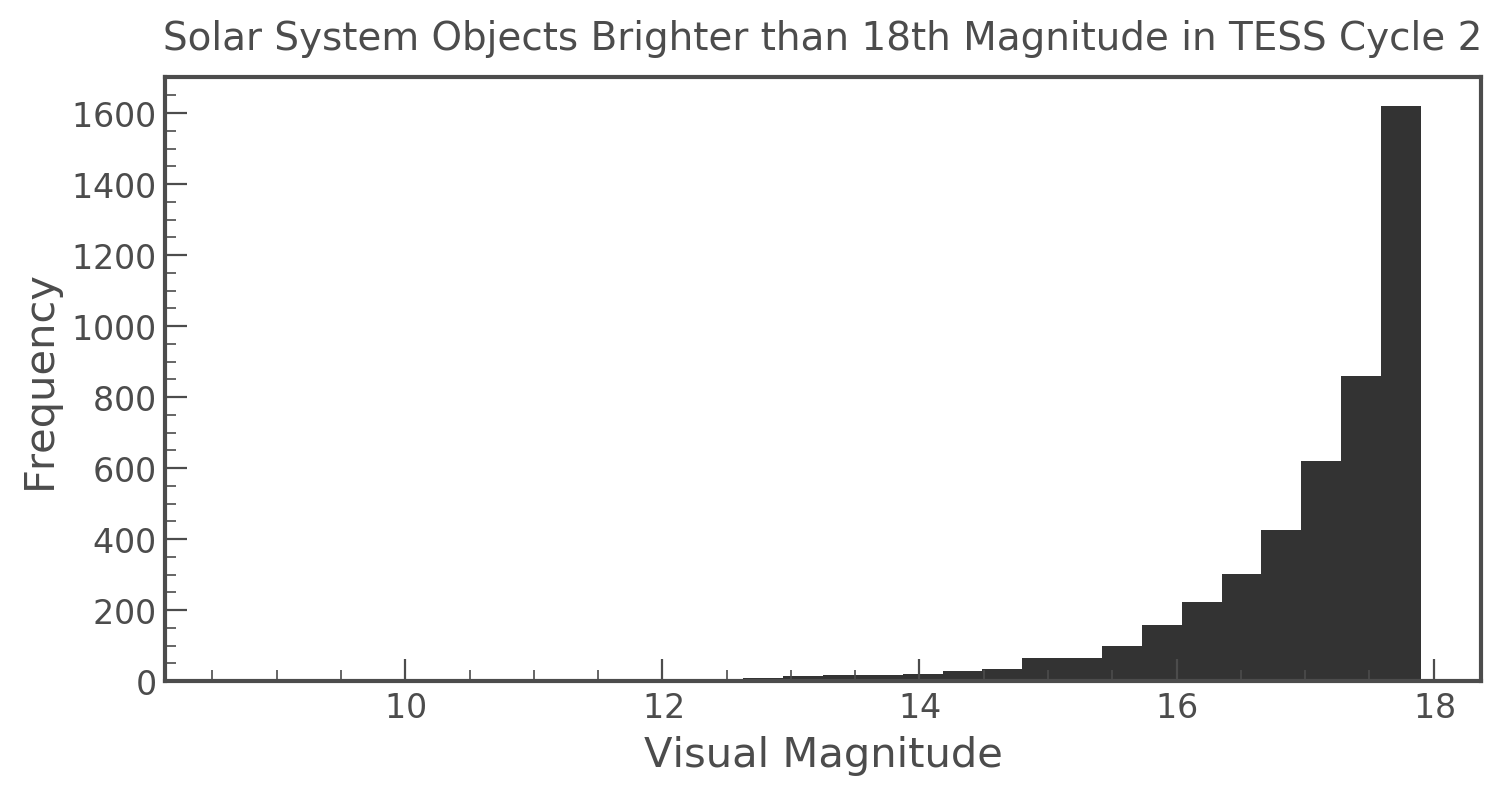

In [577]:
_ = plt.hist(result.Mv, 30);
plt.xlabel('Visual Magnitude')
plt.ylabel('Frequency')
plt.title('Solar System Objects Brighter than 18th Magnitude in TESS Cycle 2', fontsize=14)
plt.savefig('figures/tess_field_v18_hist.png', bbox_inches='tight', dpi=200)

In [ ]:
#tess = pd.DataFrame(columns=['name', 'a', 'per', 'ecc', 'inc', 'rad'])

In [628]:
for idx, name in enumerate(tqdm(result.Name)):
    if idx < len(tess):
        continue
    a, per, ecc, inc, rad = get_params(name.strip(), 'TESS')
    tess.loc[idx, tess.columns] = np.asarray([name, a, per, ecc, inc, rad]).T

100%|██████████| 4614/4614 [03:06<00:00, 24.80it/s]   


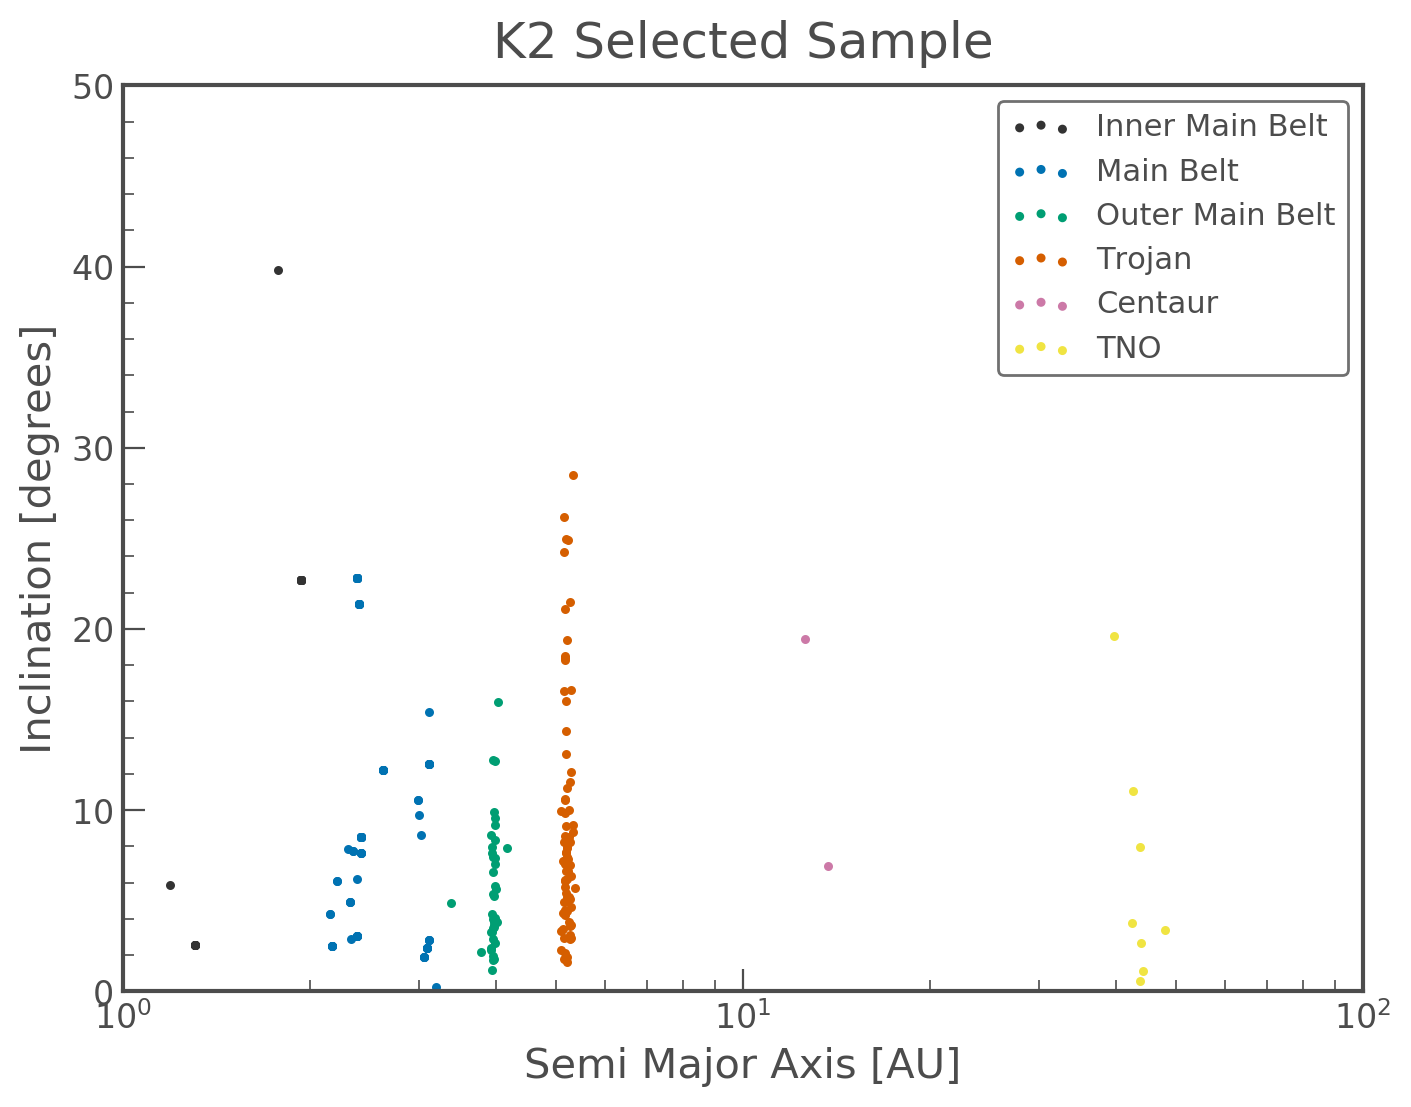

In [631]:
fig, ax = plt.subplots(figsize=(8, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    inner_main_belt = np.asarray(k2.a, float) < 2.0
    main_belt = (np.asarray(k2.a, float) > 2.0) & (np.asarray(k2.a, float) < 3.2)
    outer_main_belt = (np.asarray(k2.a, float) > 3.2) & (np.asarray(k2.a, float) < 4.6)
    jupiter_trojan = (np.asarray(k2.a, float) > 4.6) & (np.asarray(k2.a, float) < 5.5) & (np.asarray(k2.ecc, float) < 0.3)
    centaur = (np.asarray(k2.a, float) > 5.5) & (np.asarray(k2.a, float) < 30.1)
    tno = (np.asarray(k2.a, float) > 30.1)

types = [inner_main_belt, main_belt, outer_main_belt, jupiter_trojan, centaur, tno]
labels = ['Inner Main Belt', 'Main Belt', 'Outer Main Belt', 'Trojan', 'Centaur', 'TNO']

for a_type, label in zip(types, labels):
    ax.scatter(np.asarray(k2.a, float)[a_type], np.asarray(k2.inc, float)[a_type], label=label, s=5)
ax.set_ylabel('Inclination [degrees]')
ax.set_xlabel('Semi Major Axis [AU]')
ax.set_xscale('log')
ax.legend()
ax.set_title('K2 Selected Sample')

ax.set_xlim(1, 100)
ax.set_ylim(0, 50)

plt.savefig('figures/K2_sample_AU.png', dpi=200, bbox_inches='tight')

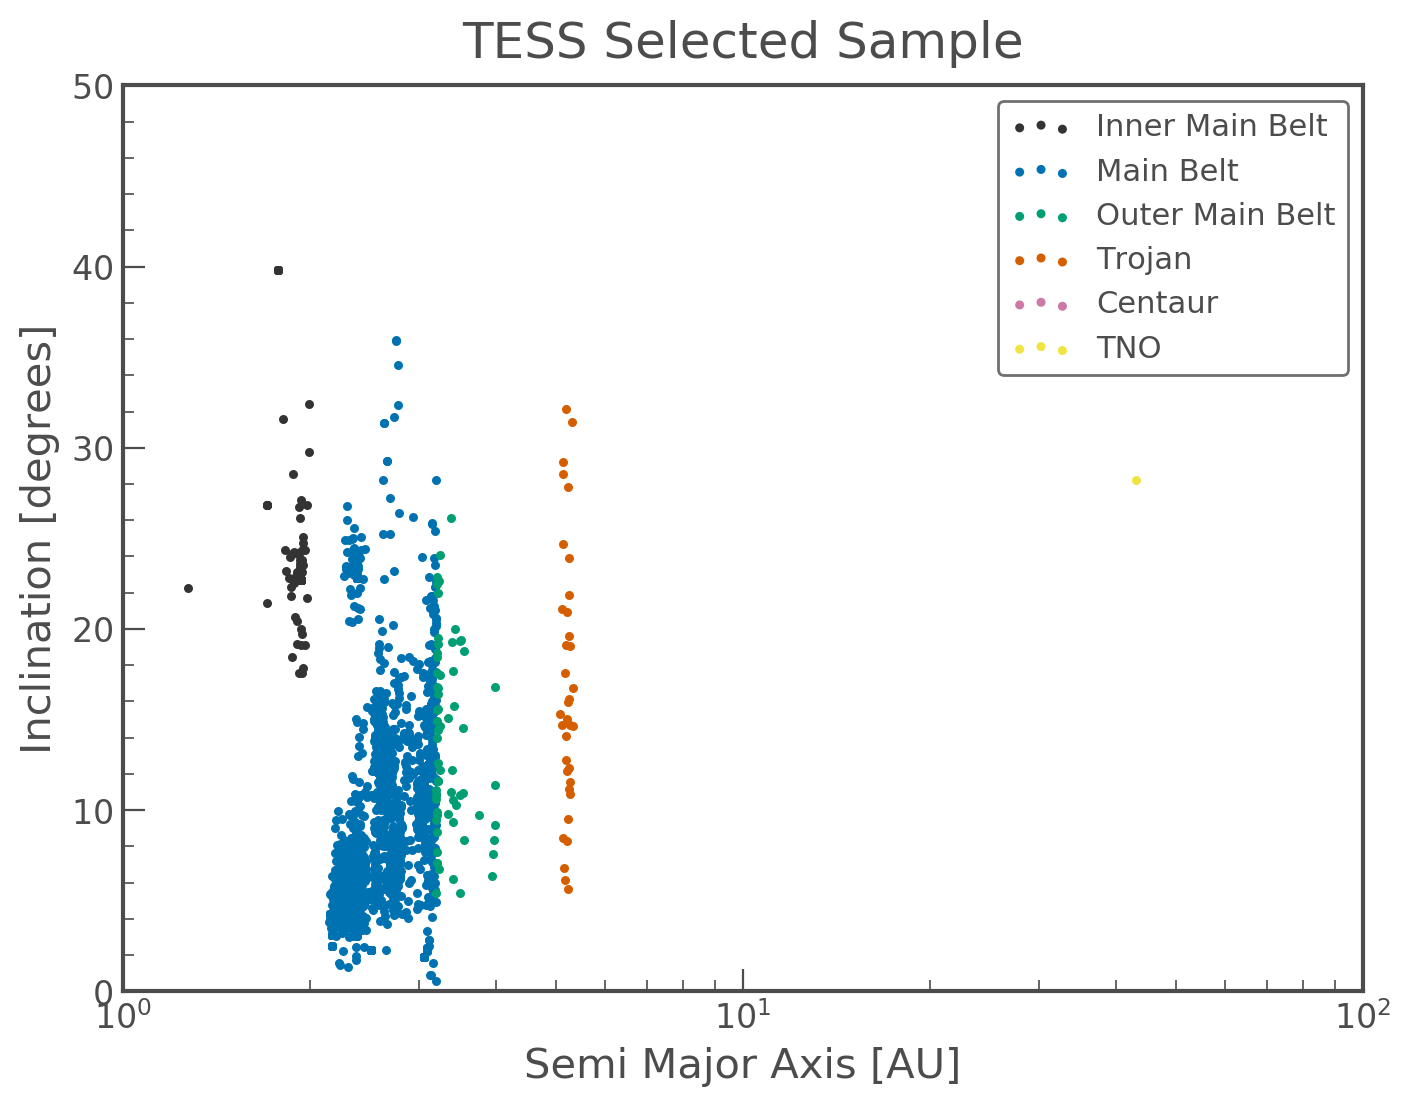

In [632]:
fig, ax = plt.subplots(figsize=(8, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    inner_main_belt = np.asarray(tess.a, float) < 2.0
    main_belt = (np.asarray(tess.a, float) > 2.0) & (np.asarray(tess.a, float) < 3.2)
    outer_main_belt = (np.asarray(tess.a, float) > 3.2) & (np.asarray(tess.a, float) < 4.6)
    jupiter_trojan = (np.asarray(tess.a, float) > 4.6) & (np.asarray(tess.a, float) < 5.5) & (np.asarray(tess.ecc, float) < 0.3)
    centaur = (np.asarray(tess.a, float) > 5.5) & (np.asarray(tess.a, float) < 30.1)
    tno = (np.asarray(tess.a, float) > 30.1)

types = [inner_main_belt, main_belt, outer_main_belt, jupiter_trojan, centaur, tno]
labels = ['Inner Main Belt', 'Main Belt', 'Outer Main Belt', 'Trojan', 'Centaur', 'TNO']

for a_type, label in zip(types, labels):
    ax.scatter(np.asarray(tess.a, float)[a_type], np.asarray(tess.inc, float)[a_type], label=label, s=5)
ax.set_ylabel('Inclination [degrees]')
ax.set_xlabel('Semi Major Axis [AU]')
ax.set_xscale('log')
ax.legend()
ax.set_title('TESS Selected Sample')

ax.set_xlim(1, 100)
ax.set_ylim(0,50)

plt.savefig('figures/TESS_sample_AU.png', dpi=200, bbox_inches='tight')

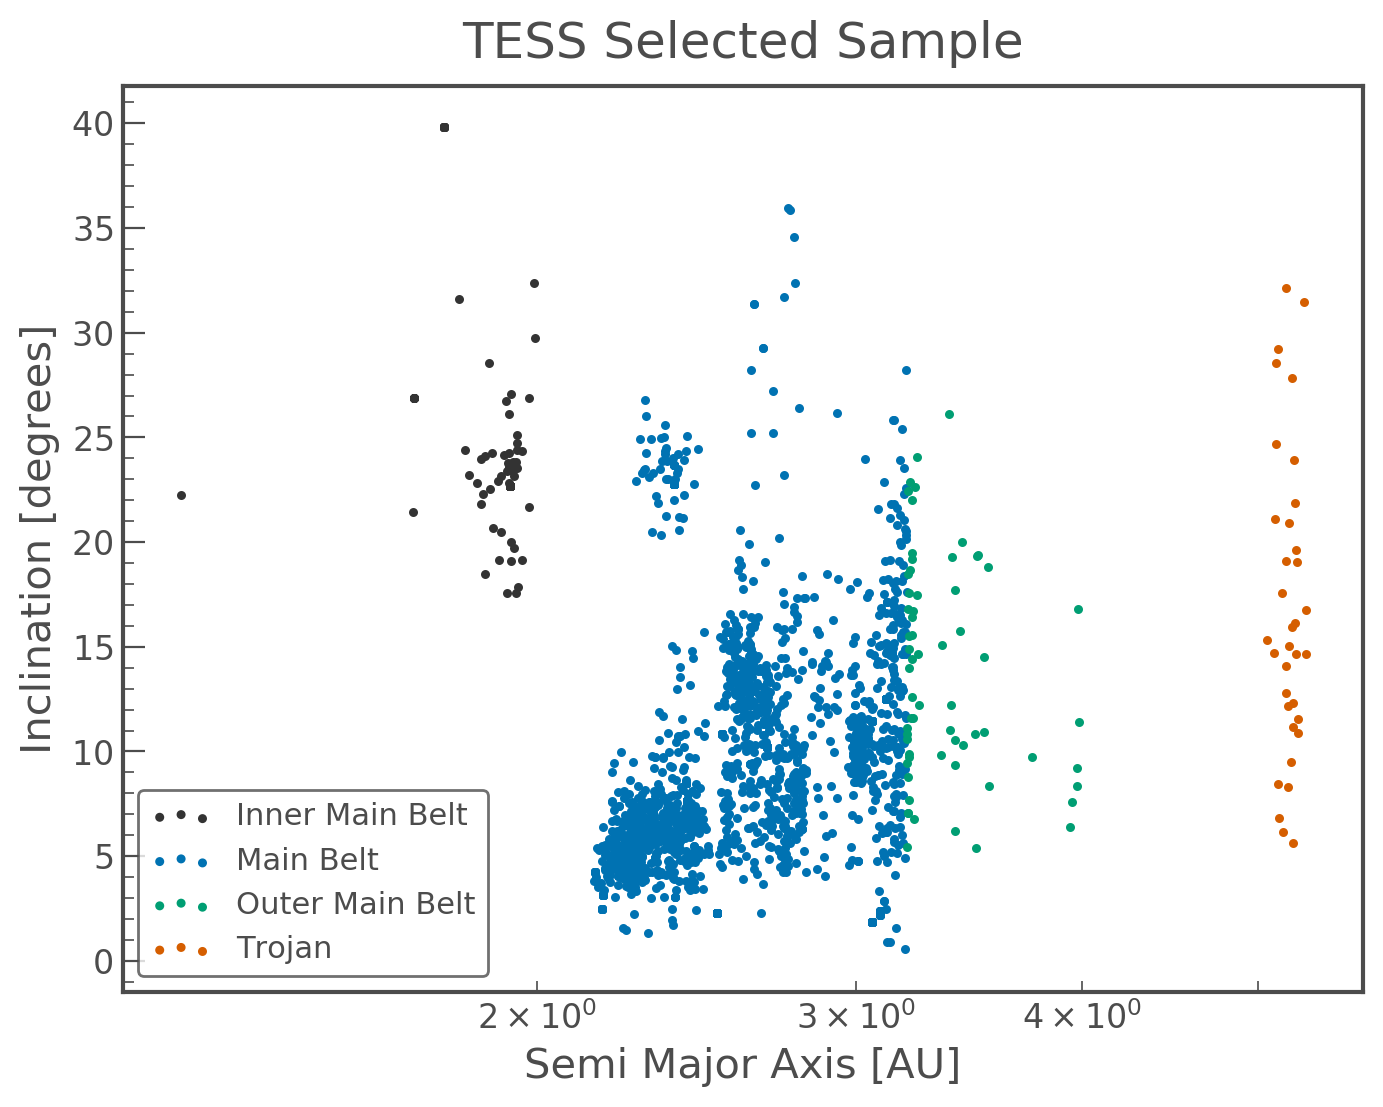

In [636]:
fig, ax = plt.subplots(figsize=(8, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    inner_main_belt = np.asarray(tess.a, float) < 2.0
    main_belt = (np.asarray(tess.a, float) > 2.0) & (np.asarray(tess.a, float) < 3.2)
    outer_main_belt = (np.asarray(tess.a, float) > 3.2) & (np.asarray(tess.a, float) < 4.6)
    jupiter_trojan = (np.asarray(tess.a, float) > 4.6) & (np.asarray(tess.a, float) < 5.5) & (np.asarray(tess.ecc, float) < 0.3)
    centaur = (np.asarray(tess.a, float) > 5.5) & (np.asarray(tess.a, float) < 30.1)
    tno = (np.asarray(tess.a, float) > 30.1)

types = [inner_main_belt, main_belt, outer_main_belt, jupiter_trojan]
labels = ['Inner Main Belt', 'Main Belt', 'Outer Main Belt', 'Trojan']

for a_type, label in zip(types, labels):
    ax.scatter(np.asarray(tess.a, float)[a_type], np.asarray(tess.inc, float)[a_type], label=label, s=5)
ax.set_ylabel('Inclination [degrees]')
ax.set_xlabel('Semi Major Axis [AU]')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_title('TESS Selected Sample')

#ax.set_xlim(1, 100)
#ax.set_ylim(0,50)

plt.savefig('figures/TESS_sample_AU.png', dpi=200, bbox_inches='tight')

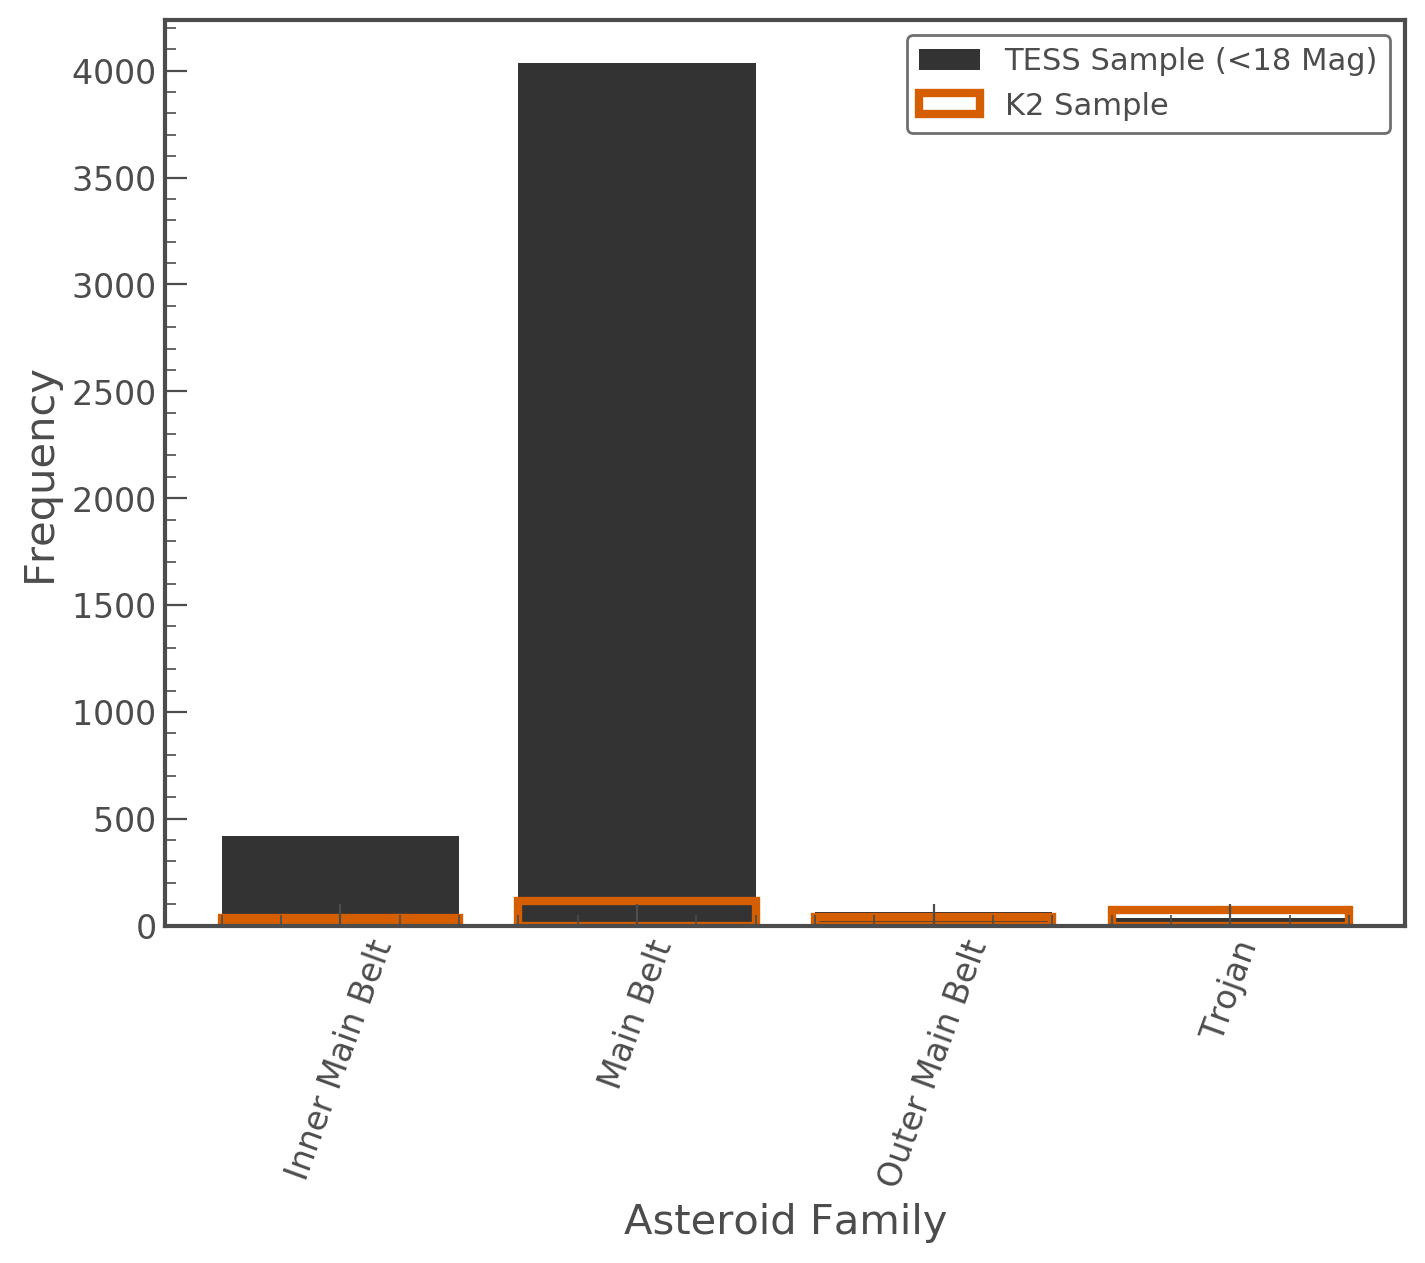

In [644]:
fig, ax = plt.subplots(figsize=(8, 6))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    inner_main_belt = np.asarray(tess.a, float) < 2.0
    main_belt = (np.asarray(tess.a, float) > 2.0) & (np.asarray(tess.a, float) < 3.2)
    outer_main_belt = (np.asarray(tess.a, float) > 3.2) & (np.asarray(tess.a, float) < 4.6)
    jupiter_trojan = (np.asarray(tess.a, float) > 4.6) & (np.asarray(tess.a, float) < 5.5) & (np.asarray(tess.ecc, float) < 0.3)
    centaur = (np.asarray(tess.a, float) > 5.5) & (np.asarray(tess.a, float) < 30.1)
    tno = (np.asarray(tess.a, float) > 30.1)

types = [inner_main_belt, main_belt, outer_main_belt, jupiter_trojan]
labels = ['Inner Main Belt', 'Main Belt', 'Outer Main Belt', 'Trojan']

h = [len(tess[type]) for type in types]
ax.bar(np.arange(len(types)), h, label='TESS Sample (<18 Mag)')



with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    inner_main_belt = np.asarray(k2.a, float) < 2.0
    main_belt = (np.asarray(k2.a, float) > 2.0) & (np.asarray(k2.a, float) < 3.2)
    outer_main_belt = (np.asarray(k2.a, float) > 3.2) & (np.asarray(k2.a, float) < 4.6)
    jupiter_trojan = (np.asarray(k2.a, float) > 4.6) & (np.asarray(k2.a, float) < 5.5) & (np.asarray(k2.ecc, float) < 0.3)
    centaur = (np.asarray(k2.a, float) > 5.5) & (np.asarray(k2.a, float) < 30.1)
    tno = (np.asarray(k2.a, float) > 30.1)

types = [inner_main_belt, main_belt, outer_main_belt, jupiter_trojan]
labels = ['Inner Main Belt', 'Main Belt', 'Outer Main Belt', 'Trojan']

h = [len(k2[type]) for type in types]
ax.bar(np.arange(len(types)), h, fill=False, edgecolor='C3', lw=3, label='K2 Sample')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=70)

#ax.set_yscale('log')
ax.legend()
ax.set_ylabel('Frequency')
ax.set_xlabel('Asteroid Family')

plt.savefig('figures/sample_comparison_histogram.png', dpi=200, bbox_inches='tight')

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


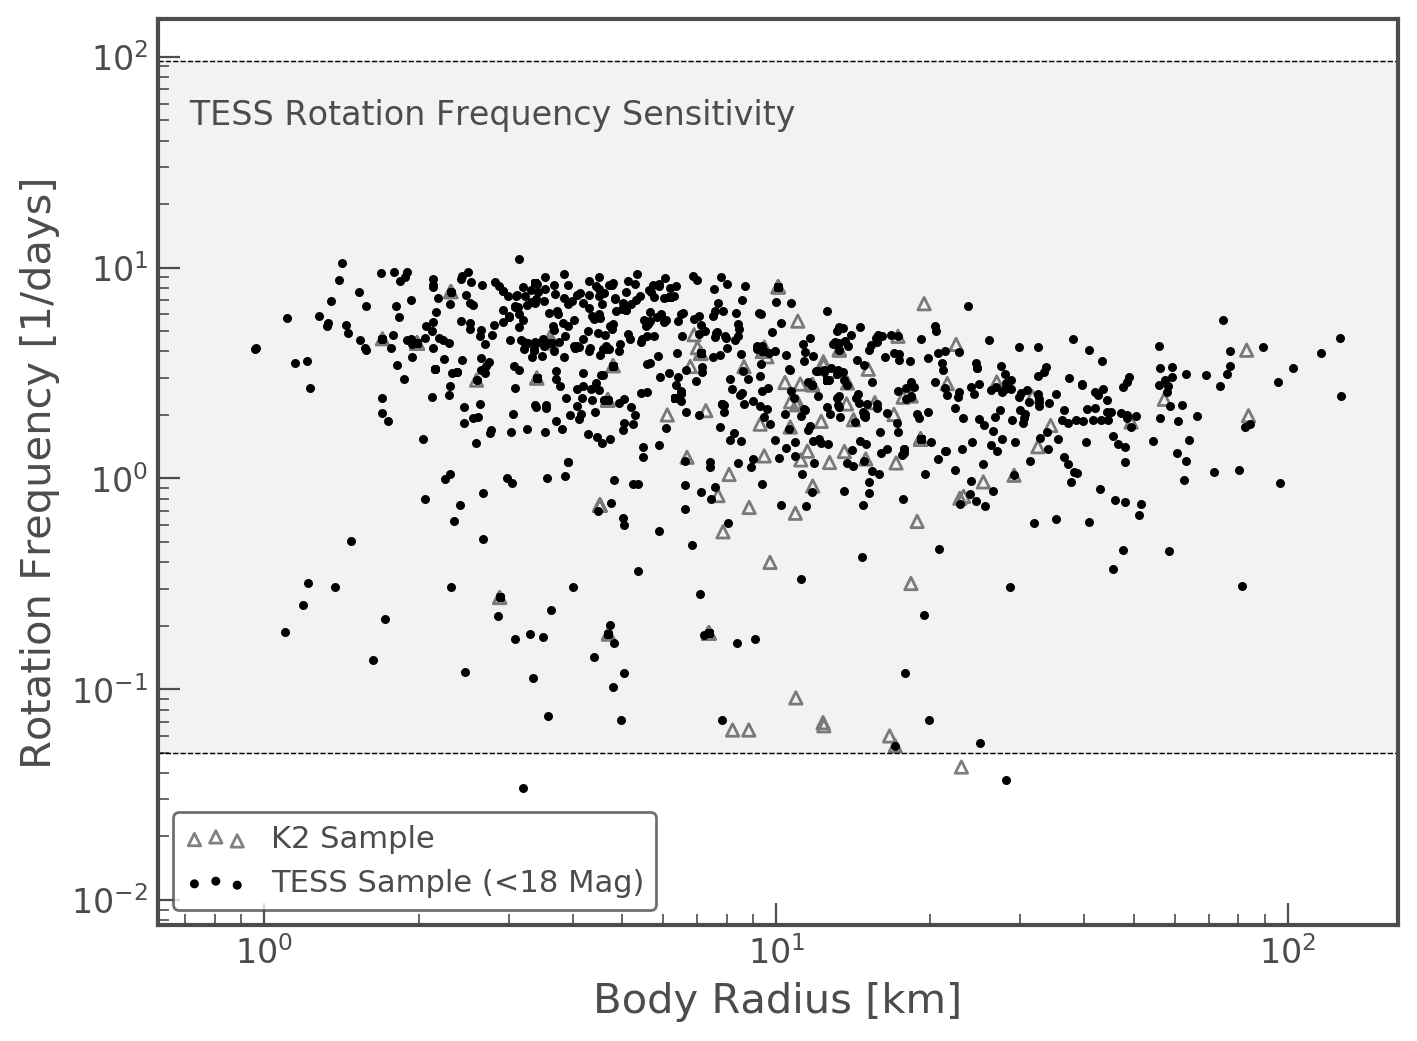

In [659]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(np.asarray(k2.rad, float), (1/(np.asarray(k2.per, float)/24)), s=20, label='K2 Sample', edgecolor='grey', facecolor='None', marker='^')
k = np.asarray(tess.rad, float) > 0.5
ax.scatter(np.asarray(tess.rad, float)[k], (1/(np.asarray(tess.per, float)/24))[k], s=20, label='TESS Sample (<18 Mag)', c='k', marker='.')
ax.axhline((1./(15*u.minute).to(u.day).value), linestyle='--', color='k')
ax.axhline((1./(20*u.day).to(u.day).value), linestyle='--', color='k')

ax.set_ylabel('Rotation Frequency [1/days]')
ax.set_xlabel('Body Radius [km]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()


xlims = ax.get_xlim()
ax.fill_between([xlims[0], xlims[1]], (1./(15*u.minute).to(u.day).value), (1./(20*u.day).to(u.day).value), color='k', alpha=0.05)
ax.set_xlim(xlims)
ax.text(xlims[0], (1./(15*u.minute).to(u.day).value), '\n   TESS Rotation Frequency Sensitivity', ha='left', va='top', fontsize=12)
plt.savefig('figures/tess_sample_R_vs_f.png', dpi=200, bbox_inches='tight')

In [649]:
np.isfinite(np.asarray(k2.per, float)).sum()/len(k2)

0.7084745762711865

In [648]:
np.isfinite(np.asarray(tess.per, float)).sum()/len(tess)

0.799306458604248

In [650]:
np.isfinite(np.asarray(tess.rad, float)).sum()/len(tess)

0.9445166883398353

In [653]:
idx = np.nanargmin(np.asarray(tess.rad, float))

In [654]:
tess.loc[idx]

name             1991 VA1 
a        2.515363885474061
per                 6.0297
ecc     0.5979795213543416
inc      2.290937394823247
rad                  0.265
Name: 23, dtype: object

In [ ]:
k2['k2_period'] = np.nan
k2['k2_power'] = np.nan
for name in tqdm(k2[np.isfinite(np.asarray(k2.per, float))].name):
    fname = glob('/Volumes/cupertino/Christina/hlsp-asteriks/output/{}/*lightcurve*_v0.5*.fits'.format(name.replace(' ','')))
    if len(fname) == 0:
        continue
    else:
        fname = fname[0]
    
    hdu = fits.open(fname)[1].data
    lc = lk.LightCurve(hdu['TIME'], hdu['FLUX'], hdu['FLUX_ERR'])
    mask = (hdu['NPIX_QUAL'] & hdu['BKG_QUAL'] & hdu['LEAD_QUAL'])
    lc = lc[mask].remove_outliers(6)
    ls = LombScargle(lc.time*u.day, lc.flux, lc.flux_err, nterms=3)
    freq, power = ls.autopower(samples_per_peak=20, maximum_frequency=((1/(3*u.hour).to(u.day))), minimum_frequency=((1/(5*u.day))))
    idx = np.where(k2.name == name)[0][0]
    k2.loc[idx, 'k2_period'] = (1/freq).to(u.hour)[np.argmax(power)].value
    k2.loc[idx, 'k2_power'] = np.max(power)

In [ ]:
plt.scatter(np.asarray(k2.per, float), k2.k2_period, c=k2.k2_power)
plt.ylabel('K2 Measured Period')
plt.xlabel('HORIZONS Period')

In [ ]:
k = k2.k2_power > 0.5
plt.scatter(np.asarray(k2.per, float)[k], k2.k2_period[k])
plt.ylabel('K2 Measured Period')
plt.xlabel('HORIZONS Period')
plt.yscale('log')
plt.xscale('log')
plt.plot([0, 100], [0, 100])

In [ ]:
aliased = res[k][np.isclose(np.asarray(k2.per, float)[k]/k2.k2_period[k], 2, atol=0.05)]
for name in aliased.name:
    fname = glob('/Volumes/cupertino/Christina/hlsp-asteriks/output/{}/*lightcurve*_v0.5*.fits'.format(name.replace(' ','')))
    if len(fname) == 0:
        continue
    else:
        fname = fname[0]
    
    hdu = fits.open(fname)[1].data
    lc = lk.LightCurve(hdu['TIME'], hdu['FLUX'], hdu['FLUX_ERR'])
    mask = (hdu['NPIX_QUAL'] & hdu['BKG_QUAL'] & hdu['LEAD_QUAL'])
    lc = lc[mask].remove_outliers(6)
    ls = LombScargle(lc.time*u.day, lc.flux, lc.flux_err, nterms=3)
    freq, power = ls.autopower(samples_per_peak=20, maximum_frequency=((1/(3*u.hour).to(u.day))), minimum_frequency=((1/(5*u.day))))
    
    x = np.linspace(lc.time.min(), lc.time.max(), 1000) * u.day
    ax = lc.errorbar(normalize=False, label='K2 Asteroid Light Curve')
    ax.plot(x, ls.model(x, freq[np.argmax(power)]), alpha=0.5, label='Best Fit Simple Model (Period: {:2.2f})'.format((1/freq[np.argmax(power)]).to(u.hour)))
    idx = np.where(k2.name == name)[0][0]
    lit_p = k2.loc[idx, 'per']
    ax.set_title('{0} (Literature Period: {1:2.2f})'.format(name, float(lit_p)*u.hour))
    ax.legend()
    #plt.savefig('figures/K2-Aliased-LightCurve.png', dpi=200, bbox_inches='tight')
    

In [ ]:
close = np.isclose(np.asarray(k2.per, float)[k]/k2.k2_period[k], 1, atol=0.1) | np.isclose(np.asarray(k2.per, float)[k]/k2.k2_period[k], 2, atol=0.1)
res[k][~close][['name', 'a', 'rad', 'per', 'k2_period', 'k2_power']]

In [ ]:
names = ['1999 TS40', '2001 RS52', '2002 XF45']
for name in names:
    fname = glob('/Volumes/cupertino/Christina/hlsp-asteriks/output/{}/*lightcurve*_v0.5*.fits'.format(name.replace(' ','')))[0]
    hdu = fits.open(fname)[1].data
    lc = lk.LightCurve(hdu['TIME'], hdu['FLUX'], hdu['FLUX_ERR'])
    mask = (hdu['NPIX_QUAL'] & hdu['BKG_QUAL'] & hdu['LEAD_QUAL'])
    lc = lc[mask].remove_outliers(6)
    ls = LombScargle(lc.time*u.day, lc.flux, lc.flux_err, nterms=3)
    freq, power = ls.autopower(samples_per_peak=20, maximum_frequency=((1/(3*u.hour).to(u.day))), minimum_frequency=((1/(5*u.day))))

    x = np.linspace(lc.time.min(), lc.time.max(), 1000) * u.day
    ax = lc.errorbar(normalize=False, label='K2 Asteroid Light Curve')
    ax.plot(x, ls.model(x, freq[np.argmax(power)]), alpha=0.5, label='Best Fit Simple Model (Period: {:2.2f})'.format((1/freq[np.argmax(power)]).to(u.hour)))
    idx = np.where(k2name == name)[0][0]
    lit_p = k2loc[idx, 'per']
    ax.set_title('{0} (Literature Period: {1:2.2f})'.format(name, float(lit_p)*u.hour))
    ax.legend()
    #plt.savefig('figures/K2-Aliased-LightCurve.png', dpi=200, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 13))
names = ['1999 TS40', '2001 RS52', '2002 XF45']
labels = ['Tumbler/Complex Rotation', 'Faint Objects', 'Long Period Variability']
for jdx, name in enumerate(names):
    fname = glob('/Volumes/cupertino/Christina/hlsp-asteriks/output/{}/*lightcurve*_v0.5*.fits'.format(name.replace(' ','')))[0]
    hdu = fits.open(fname)[1].data
    lc = lk.LightCurve(hdu['TIME'], hdu['FLUX'], hdu['FLUX_ERR'])
    mask = (hdu['NPIX_QUAL'] & hdu['BKG_QUAL'] & hdu['LEAD_QUAL'])
    lc = lc[mask].remove_outliers(6)
    ls = LombScargle(lc.time*u.day, lc.flux, lc.flux_err, nterms=3)
    freq, power = ls.autopower(samples_per_peak=20, maximum_frequency=((1/(3*u.hour).to(u.day))), minimum_frequency=((1/(5*u.day))))

    x = np.linspace(lc.time.min(), lc.time.max(), 1000) * u.day
    lc.errorbar(normalize=False, ax=axs[jdx], c='k', label='K2 Light Curve ()'.format(name))


    if jdx == 0:
        axs[jdx].plot(x, ls.model(x, freq[np.argmax(power)]), c='C1', lw=2, alpha=0.2, label='Best Fit Simple Model')
        axs[jdx].legend()
    if jdx == 1:
        axs[jdx].plot(x, ls.model(x, freq[np.argmax(power)]), c='C1', lw=2, alpha=0.7, label='Best Fit Simple Model')
        axs[jdx].legend(2)
    if jdx == 2:
        axs[jdx].fill_between(x, ls.model(x, freq[np.argmax(power)])-50, ls.model(x, freq[np.argmax(power)])+50, color='C1', alpha=0.1, lw=0, label='Best Fit Simple Model')
        axs[jdx].legend(loc=4)
        
    bf_period = (1/freq[np.argmax(power)]).to(u.hour)

    ylims = axs[jdx].get_ylim()
    dy = ylims[1] - ylims[0]
    axs[jdx].set_ylim(ylims[0] - (dy * 0.2), ylims[1] + (dy * 0.2))
    ylims = axs[jdx].get_ylim()


    axs[jdx].text(lc.time[0], ylims[-1], '\n{}\nLiterature Period: {:2.2f}, Best Fit Period {:2.2f}'.format(name, float(lit_p)*u.hour, bf_period), ha='left', va='top', fontsize=11)
    
    axs[jdx].text(lc.time[0], ylims[0] + (ylims[1] - ylims[0]) * 0.15, '{}'.format(labels[jdx]), ha='left', va='top', fontsize=15)


    #axs[jdx].set_title('{0} (Literature Period: {1:2.2f})'.format(name, float(lit_p)*u.hour))

    axs[jdx].set_xlabel('')
    idx = np.where(k2.name == name)[0][0]
    lit_p = k2.loc[idx, 'per']


axs[jdx].set_xlabel('Time [JD]')
plt.savefig('figures/K2-Examples.png', dpi=200, bbox_inches='tight')



In [630]:
tess.to_pickle('christina/tess.p')
k2.to_pickle('christina/k2.p')

In [629]:
tess.shape

(4614, 6)